# DCG model (Keras generator)

Scaling up from difficulty.

(Forward model)

# Packages

In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, ZeroPadding2D
from keras.layers import Dense, BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D
from keras.layers import Conv2DTranspose, UpSampling2D, LeakyReLU, Dropout
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


# Load Data

In [2]:
# Load the Drive helper and mount (Authorization)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import h5py
import pandas as pd
os.chdir('/content/drive/My Drive/LLNL')

In [4]:
def load_data(train_path,test_path):
    # read in Data
    tests_data = test_path ; train_data = train_path;
    ts_df = h5py.File(tests_data,'r') ; tr_df = h5py.File(train_data,'r') ;
    # Scan for images and grab labels
    y_train = np.array(tr_df['images'])
    X_train = np.array([tr_df['images'][i][0] for i in y_train])
    y_test = np.array(ts_df['images'])
    X_test = np.array([ts_df['images'][i][0] for i in y_test])
    # close h5py
    ts_df.close() ; tr_df.close()
    return (X_train*1.0, X_test*1.0)

train_path = 'new_training_data.h5'
test_path = 'new_test_data.h5'
(X_train, X_test) = load_data(train_path,test_path)
X_train.shape +  X_test.shape # images will be labels for this model.

(16771, 100, 100, 7214, 100, 100)

In [0]:
# Parameter Data to use
train_df = pd.read_csv("param_search.csv", sep = ",")
test_df = pd.read_csv("param_search2.csv", sep = ",")

# Manipulate Data

In [0]:
## Resizing data to n by n image. (Not necessary for 100 by 100 images)
# n = 25; n = n/100
#import scipy.ndimage as ndi
#X_train = ndi.zoom(X_train, (1, n, n), order=2)
#X_test = ndi.zoom(X_test, (1, n, n), order=2)
#np.shape(X_train) + np.shape(X_test)

In [0]:
# Normalize Data.
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))

# Keras Sequential Model..

In [8]:
model = Sequential()

# In: 3
# Hidden Layers and Resizing
model.add(Dense(25, activation='relu', input_shape=(3,)))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(625, activation = 'relu'))
model.add(Reshape((5, 5, 25)))
model.add(Dropout(0.4))

# Deconvolution Layers
model.add(UpSampling2D())
model.add(Conv2DTranspose(int(25/2), 5, padding='same'))
model.add(Dropout(0.4))

model.add(UpSampling2D())
model.add(BatchNormalization(momentum=0.9))
model.add(Conv2DTranspose(int(25/8), 5, padding='same'))


# Output Layers
model.add(Flatten())
model.add(BatchNormalization(momentum=0.9))
model.add(Dense(10000, activation=None))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_3 (Dense)              (None, 625)               63125     
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 25)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 25)          0         
_________________________________________________________________
up_sampling2d_1 (UpSa

In [0]:
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.004),metrics=['mean_squared_error'])

# Training Model

In [10]:
model.fit(train_df,np.reshape(X_train,(16771,10000)), batch_size = 128, epochs = 100, shuffle = True) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
16771/16771 [==============================] - 11s 648us/step - loss: 0.0468 - mean_squared_error: 0.0468
Epoch 2/100
16771/16771 [==============================] - 6s 357us/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 3/100
16771/16771 [==============================] - 6s 369us/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 4/100
16771/16771 [==============================] - 6s 339us/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 5/100
16771/16771 [==============================] - 5s 323us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 6/100
16771/16771 [==============================] - 6s 330us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 7/100
16771/16771 [==============================] - 5s 323us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 8/100
16771/16771 [==============================] - 6s 335us/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 9/100
167

# Predictions

First image is out of sample. Second image is out of sample.

In [11]:
# Grab image from dataset.
print(train_df.iloc[1014:1015,])
print(test_df.iloc[100:101,])

         p        phi       theta
1014 -10.0  28.344843  154.488875
            p   phi       theta
100 -0.786348  90.0  164.850871


### Out of Sample

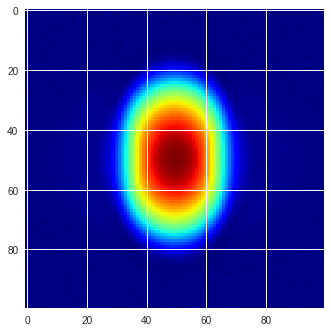

In [46]:
huh = model.predict(test_df.iloc[1111:1112,])
plt.imshow(np.reshape(huh,(100,100)),cmap = 'jet')

Real Image Comparison for Out of Sapmle

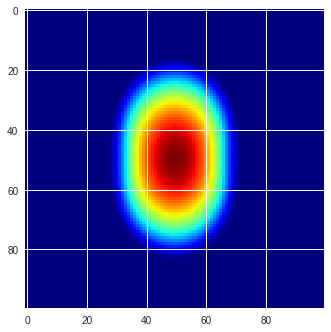

In [47]:
plt.imshow(np.reshape(X_test[1111], (100,100)), cmap = 'jet')

### In Sample

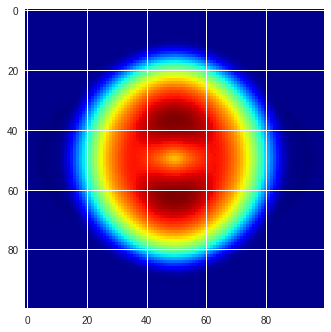

In [33]:
huh = model.predict(train_df.iloc[1014:1015,])
plt.imshow(np.reshape(huh,(100,100)),cmap = 'jet')

Real image for in sample

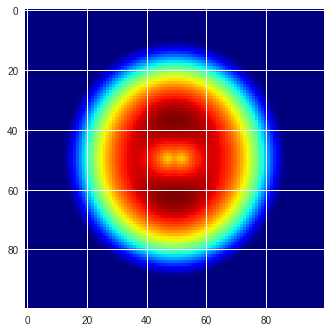

In [34]:
plt.imshow(np.reshape(X_train[1015], (100,100)), cmap = 'jet')

# Evaluate/Benchmark model

In [16]:
model.evaluate(test_df, np.reshape(X_test,(7214,10000))) # Test < train. Good sign but 100 epochs may be a bit too many.

7214/7214 [==============================] - 2s 261us/step


[9.592701110177853e-05, 9.592701110177853e-05]

# Save Model

In [0]:
model.save('DCG_128.h5')

### What is being saved
- Weights
- Training Configuration
- Optimizer state
- Architecture

# Load the model...

In [0]:
from keras.models import load_model
param_plasma = load_model('DCG_128.h5')

In [19]:
# Generate Random values.
p = np.random.uniform(-10, 10, 1)
theta = np.random.uniform(0, 90, 1)
phi = np.random.uniform(0,180, 1)
trial = [p, theta, phi]
check = pd.DataFrame([trial], columns= ['p','theta','phi'])
check

,p,theta,phi
0,[-3.501837757377406],[14.682223209898996],[179.41073308174217]


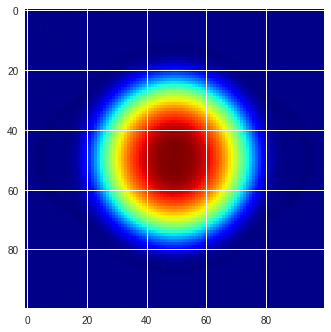

In [20]:
# Predict
hmm = param_plasma.predict(check.iloc[0:1])
plt.imshow(np.reshape(hmm,(100,100)),cmap = 'jet')

### Compare with closest image from database